##### Load library and packages

In [23]:
import torch
import torch.nn as nn
from helper.models.bert_labeler import BertLabeler
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pylab as plt
import os

##### Set arguments

In [24]:
checkpoint_path = '/home/workspace/src/tag_predictor/helper/saved_model.pth'
pretrain_path = 'bert-base-uncased'
max_tag_length = 50

##### Load saved data including checkpoint 

In [25]:
saved_data = torch.load(
    checkpoint_path,
    map_location='cuda'
)

train_config = saved_data['config']
checkpoint = saved_data['bert']
index_to_tag = saved_data['index_to_tag']

##### Load fine-tuned model from checkpoint and tokenizer

In [26]:
tokenizer = saved_data['tokenizer']
bert_labeler = BertLabeler(
    train_config,
    num_tags=len(index_to_tag),
    pretrain_path=pretrain_path,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", torch.cuda.device_count(), "GPUs!")
bert_labeler = bert_labeler.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(bert_labeler)
msg = bert_labeler.load_state_dict(checkpoint, strict=False)
msg

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using 2 GPUs!


<All keys matched successfully>

##### To encode tag into embedding, we only need encoder of bert_labeler

In [27]:
model = bert_labeler.module.bert
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

##### Get top 100 tags

In [28]:
top_tags = list(index_to_tag.values())[:100]
top_tags

['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'asp.net',
 'mysql',
 'html',
 '.net',
 'ios',
 'objective-c',
 'sql',
 'css',
 'ruby-on-rails',
 'linux',
 'c',
 'windows',
 'ruby',
 'sql-server',
 'wpf',
 'xml',
 'ajax',
 'regex',
 'database',
 'asp.net-mvc',
 'xcode',
 'django',
 'arrays',
 'osx',
 'vb.net',
 'windows-7',
 'eclipse',
 'json',
 'facebook',
 'ruby-on-rails-3',
 'string',
 'performance',
 'multithreading',
 'winforms',
 'ubuntu',
 'visual-studio-2010',
 'asp.net-mvc-3',
 'image',
 'html5',
 'networking',
 'homework',
 'wordpress',
 'security',
 'wcf',
 'bash',
 'forms',
 'algorithm',
 'web-services',
 'query',
 'linq',
 'visual-studio',
 'oracle',
 'git',
 'sql-server-2008',
 'perl',
 'r',
 'spring',
 'apache',
 'ipad',
 'actionscript-3',
 'flash',
 'swing',
 'silverlight',
 'cocoa-touch',
 'cocoa',
 'hibernate',
 'excel',
 'email',
 'entity-framework',
 'file',
 'api',
 'apache2',
 'jquery-ui',
 'flex',
 'list',
 'delphi',
 

##### Generate encoded data of tags using tokenizer

In [29]:
encoding = tokenizer(text=top_tags, 
                     max_length=max_tag_length, 
                     truncation=True, padding='max_length', 
                     return_tensors='pt')
encoding['input_ids'].shape

torch.Size([100, 50])

##### Feed encoded data into model, and get last hidden state

In [30]:
with torch.no_grad():
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    embeddings = model(input_ids, 
                       attention_mask).last_hidden_state

##### Define function to get Tag embedding using the output of bert encoder
>> There are two method: mean_embedding and cls_embedding

In [31]:
def get_cls_embedding(embeddings):
    # embeddings = (batch_size, max_len, hidden_size)

    return embeddings[:, 0, :]

def get_mean_embedding(embeddings, attention_mask):
    # embeddings = (batch_size, max_len, hidden_size)
    
    # Convert value of embedding value corresponding to mask into 0
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask

    sum_embeddings = torch.sum(masked_embeddings, axis=1)
    # sum_embeddings = (batch_size, hidden_size)

    sum_mask = torch.clamp(mask.sum(1), min=1e-9)
    mean_embeddings = sum_embeddings / sum_mask
    # mean_embeddings = (batch_size, hidden_size)

    return mean_embeddings

##### Get mean embedding or cls embedding

In [32]:
tag_embeddings = get_mean_embedding(embeddings, attention_mask)
#tag_embeddings = get_cls_embedding(embeddings)

tag_embeddings.shape

torch.Size([100, 768])

##### Calculate cosine similarity for top 100 tags, and get similarity matrix

In [33]:
tag_embeds = tag_embeddings.detach().cpu().numpy()
sim_maxtirx = cosine_similarity(tag_embeds,tag_embeds)

sim_maxtirx.shape

(100, 100)

##### Visualize Tag similarity matrix using heatmap

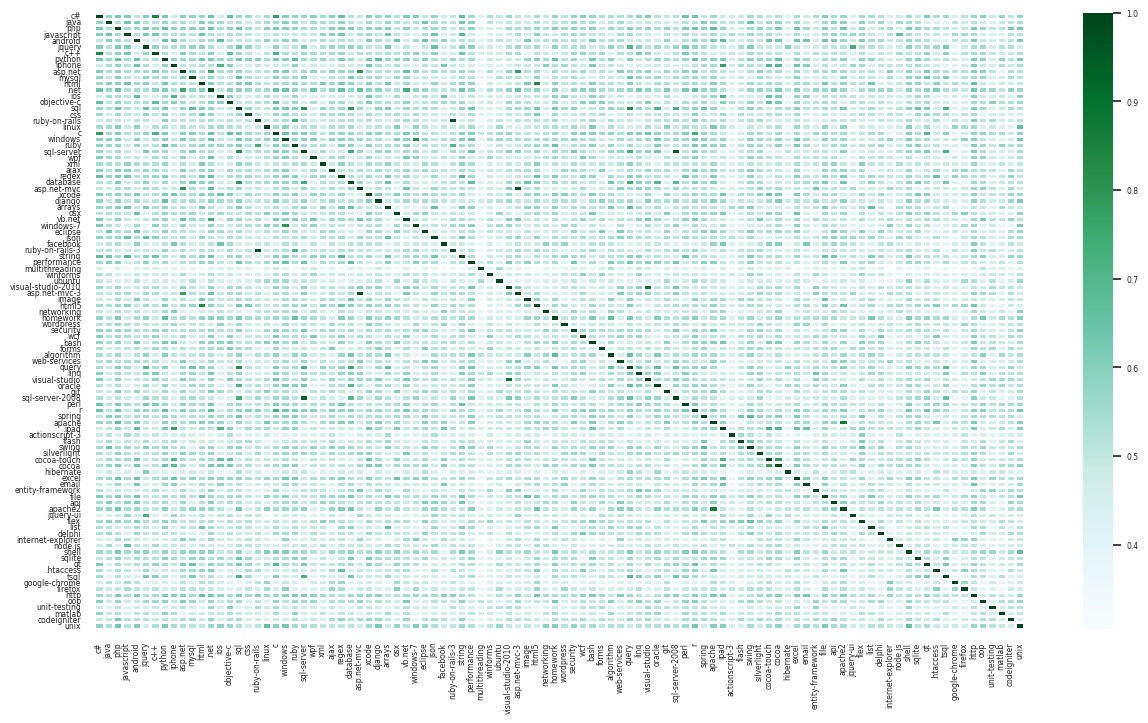

In [41]:
sns.set(font_scale=0.5,
        rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(sim_maxtirx,
                 xticklabels=top_tags,
                 yticklabels=top_tags,
                #  annot=True,
                 linewidth=1,
                 cmap='BuGn')

plt.show()